## Importing of Libraries and Reading of File

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
text = input("Enter the file path for the csv file containing the price-demand data")
df = pd.read_csv(text)

Enter the file path for the csv file containing the price-demand data price_demand_data.csv


In [5]:
df.head(2)

,price,demand
0,1.05,283
1,0.86,771


In [6]:
df.value_counts()

price  demand
0.82   925       2
0.76   1002      1
1.08   438       1
1.13   375       1
       321       1
                ..
0.93   796       1
       739       1
       320       1
0.92   703       1
1.25   334       1
Name: count, Length: 98, dtype: int64

## Fitting in Linear Regression Model

In [8]:
X = df['price'].values.reshape(-1, 1)
y = df['demand'].values 

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_

In [9]:
print(f"Linear Regression Model: demand = {slope:.2f} * price + {intercept:.2f}")

Linear Regression Model: demand = -1367.71 * price + 1924.72


In [10]:
r2_value = model.score(X, y)
print("R² value:", r2_value)

R² value: 0.6214724117783328


## Generate new demand data using residuals and calculate the predicted values based on the model

In [12]:
df['predicted_demand'] = model.predict(X)

In [13]:
df['residuals'] = df['demand'] - df['predicted_demand']

In [14]:
p = 1 #This is the given price 
df['new_demand'] = slope * p + intercept + df['residuals']

In [15]:
df.head(1)

,price,demand,predicted_demand,residuals,new_demand
0,1.05,283,488.619393,-205.619393,351.385626


**Intializing other given variables**

In [17]:
c = 0.5  # Cost per regular unit produced
g = 0.75  # Rush order cost per unit if demand exceeds production
t = 0.15  # Disposal cost per excess unit produced

## Solving the optimal quantity to produce when given price = 1

In [19]:
model = gp.Model("Optimal_Quantity")
n = df.shape[0]

# Decision variable: Quantity to produce (q)
q = model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="q")

# Dummy variables for each day representing profit (h_i)
h = model.addVars(n, lb=-gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="h")

# Set objective: Maximize the average profit across all days
model.setObjective(gp.quicksum(h[i] for i in range(n)) / n, gp.GRB.MAXIMIZE)

# Add constraints for each observation
demands = df['new_demand'].values
for i in range(n):
    model.addConstr(h[i] <= p * demands[i] - q * c)
    model.addConstr(h[i] <= p * q - q * c) 

# Suppress solver output
model.Params.OutputFlag = 0
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26


In [20]:
optimal_quantity = q.X
print("Optimal Quantity to Produce:", optimal_quantity)
optimal_profit = sum(h[i].X for i in range(n)) / n
print("Optimal Average Profit:", optimal_profit)

Optimal Quantity to Produce: 569.8967553157715
Optimal Average Profit: 219.2831655285144


## Extension 1: Considering Rush Order Cost and Disposal Cost

In [22]:
import gurobipy as gp

model = gp.Model("Optimal_Quantity_Extension")
n = df.shape[0]

# Decision variable: Quantity to produce (q)
q = model.addVar(vtype=gp.GRB.CONTINUOUS, name="q", lb=0)

# Dummy variables for each day representing profit (h_i)
h = model.addVars(n, lb=-gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="h")

# Auxiliary variables for positive parts
shortage = model.addVars(n, lb=0, vtype=gp.GRB.CONTINUOUS, name="shortage")  # (D_i - q)+
excess = model.addVars(n, lb=0, vtype=gp.GRB.CONTINUOUS, name="excess")      # (q - D_i)+

# Set objective: Maximize the average profit
model.setObjective(gp.quicksum(h[i] for i in range(n)) / n, gp.GRB.MAXIMIZE)

# Add constraints for each observation
demands = df['new_demand'].values
for i in range(n):
    # shortage constraint = (D_i - q)+
    model.addConstr(shortage[i] >= demands[i] - q)
    model.addConstr(shortage[i] >= 0)
    
    # excess constraint = (q - D_i)+
    model.addConstr(excess[i] >= q - demands[i])
    model.addConstr(excess[i] >= 0)
    
    # Profit constraint
    # h[i] = pD_i - qc - g(D_i - q)+ - t(q - D_i)+
    model.addConstr(h[i] == p * demands[i] - q * c - 
                   g * shortage[i] - t * excess[i])

model.Params.OutputFlag = 0
model.optimize()

optimal_quantity = q.X
optimal_profit = model.objVal
print("Optimal Quantity to Produce:", optimal_quantity)
print("Expected Profit:",'$',optimal_profit)

Optimal Quantity to Produce: 471.86537959089355
Expected Profit: $ 231.4836666471413


## Extension 2: Assumption of price impacting demand linearly with error

Intercept and slope is calculated at the top 

In [25]:
print(intercept)

1924.7175435291083


In [26]:
print(slope)

-1367.712524162598


In [27]:
beta0 = intercept
beta1 = slope
residuals = df['residuals'].values

model = gp.Model("price_quantity_optimization")

# Decision variables
q = model.addVar(name="quantity", lb=0)
p = model.addVar(name="price", lb=0)

# Dummy variables for each day's profit
n = len(residuals)
h = model.addVars(n, lb=-GRB.INFINITY, name="daily_profits")

# auxiliary variables for shortages and excesses
shortage = model.addVars(n, lb=0, vtype=gp.GRB.CONTINUOUS, name="shortage")  # (D_i - q)+
excess = model.addVars(n, lb=0, vtype=gp.GRB.CONTINUOUS, name="excess")      # (q - D_i)+

# objective: maximize average profit
model.setObjective(gp.quicksum(h[i] for i in range(n))/n, GRB.MAXIMIZE)

# Add constraints for each day's profit
for i in range(n):
    # shortage = (D_i - q)+
    model.addQConstr(shortage[i] >= (beta0 + beta1*p + residuals[i]) - q)
    model.addConstr(shortage[i] >= 0)
    
    # excess = (q - D_i)+
    model.addQConstr(excess[i] >= q - (beta0 + beta1*p + residuals[i]))
    model.addConstr(excess[i] >= 0)
    
    # Profit constraint using shortage and excess variables
    model.addQConstr(h[i] == p*(beta0 + beta1*p + residuals[i]) - c*q - 
                     g*shortage[i] - t*excess[i])

model.Params.OutputFlag = 0
model.optimize()
optimal_price = p.X
optimal_quantity = q.X
expected_profit = model.objVal

print("Optimal Price: $", optimal_price)
print("Optimal Quantity:", optimal_quantity)
print("Expected Profit: $", expected_profit)

Optimal Price: $ 0.9536155905679063
Optimal Quantity: 535.3059172970538
Expected Profit: $ 234.42493540226369


<br>

## Bootstrapping the data and fitting new betas to the newly simulated data

In [30]:
import gurobipy as gp
import numpy as np
from sklearn.linear_model import LinearRegression

# Bootstrapping and solving using Gurobi
bootstrap_iterations = 1000
optimal_prices = []
optimal_quantities = []
profits = []

for iteration in range(bootstrap_iterations):
    # Bootstrap sample from original price-demand dataset
    bootstrap_sample = df.sample(n=len(df), replace=True)
    
    # Fit new regression on bootstrap sample
    X_bootstrap = bootstrap_sample['price'].values.reshape(-1, 1)
    y_bootstrap = bootstrap_sample['demand'].values
    reg_bootstrap = LinearRegression()
    reg_bootstrap.fit(X_bootstrap, y_bootstrap)
    
    # Get new beta coefficients
    beta0_bootstrap = reg_bootstrap.intercept_
    beta1_bootstrap = reg_bootstrap.coef_[0]
    residuals_bootstrap = y_bootstrap - reg_bootstrap.predict(X_bootstrap)
    
    # Create Gurobi model for each bootstrap iteration
    model = gp.Model("Optimal_Price_Quantity_Bootstrap")
    
    # Decision variables: Price (p) and Quantity to produce (q)
    p = model.addVar(vtype=gp.GRB.CONTINUOUS, name="p", lb=0)
    q = model.addVar(vtype=gp.GRB.CONTINUOUS, name="q", lb=0)
    
    # Dummy variables for each day representing profit (h_i)
    n = len(residuals_bootstrap)
    h = model.addVars(n, lb=-gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="h")
    
    # Auxiliary variables for shortage and excesses
    shortage = model.addVars(n, lb=0, vtype=gp.GRB.CONTINUOUS, name="shortage")
    excess = model.addVars(n, lb=0, vtype=gp.GRB.CONTINUOUS, name="excess")
    
    # Set objective: Maximize the average profit
    model.setObjective(gp.quicksum(h[i] for i in range(n)) / n, gp.GRB.MAXIMIZE)
    
    # Add constraints for each observation
    for i in range(n):
        # Demand at any price p will be: beta0 + beta1*p + residuals[i]
        model.addQConstr(h[i] <= p*(beta0_bootstrap + beta1_bootstrap*p + residuals_bootstrap[i]) - 
                        c*q - g*shortage[i] - t*excess[i])
        
        # shortage = (D_i - q)+
        model.addQConstr(shortage[i] >= (beta0_bootstrap + beta1_bootstrap*p + residuals_bootstrap[i]) - q)
        model.addConstr(shortage[i] >= 0)
        
        # excess = (q - D_i)+
        model.addQConstr(excess[i] >= q - (beta0_bootstrap + beta1_bootstrap*p + residuals_bootstrap[i]))
        model.addConstr(excess[i] >= 0)
    
    
    model.Params.OutputFlag = 0
    model.optimize()
    
    # Store and print results from each bootstrap iteration
    if model.status == gp.GRB.OPTIMAL:
        optimal_price = p.X
        optimal_quantity = q.X
        profit = model.objVal
        optimal_prices.append(optimal_price)
        optimal_quantities.append(optimal_quantity)
        profits.append(profit)
        
        print(f"Iteration {iteration + 1}")
        print(f"Beta0: {beta0_bootstrap:.2f}, Beta1: {beta1_bootstrap:.2f}")
        print(f"Optimal Price: ${optimal_price:.2f}")
        print(f"Optimal Quantity: {optimal_quantity:.2f}")
        print(f"Expected Profit: ${profit:.2f}")
        print("-" * 50)  # Separator line for better readability
    else:
        print(f"Iteration {iteration + 1}: Failed to find optimal solution")
        print("-" * 50)

# Print summary statistics at the end
print("\nBootstrap Analysis Summary:")
print(f"Average Optimal Price: ${np.mean(optimal_prices):.2f} ± {np.std(optimal_prices):.2f}")
print(f"Average Optimal Quantity: {np.mean(optimal_quantities):.2f} ± {np.std(optimal_quantities):.2f}")
print(f"Average Expected Profit: ${np.mean(profits):.2f} ± {np.std(profits):.2f}")

Iteration 1
Beta0: 1907.60, Beta1: -1370.56
Optimal Price: $0.95
Optimal Quantity: 523.47
Expected Profit: $229.62
--------------------------------------------------
Iteration 2
Beta0: 1756.19, Beta1: -1202.95
Optimal Price: $0.98
Optimal Quantity: 508.55
Expected Profit: $233.02
--------------------------------------------------
Iteration 3
Beta0: 2039.60, Beta1: -1481.18
Optimal Price: $0.94
Optimal Quantity: 585.10
Expected Profit: $235.25
--------------------------------------------------
Iteration 4
Beta0: 1958.94, Beta1: -1396.99
Optimal Price: $0.95
Optimal Quantity: 545.65
Expected Profit: $244.45
--------------------------------------------------
Iteration 5
Beta0: 1815.68, Beta1: -1265.81
Optimal Price: $0.97
Optimal Quantity: 496.58
Expected Profit: $229.26
--------------------------------------------------
Iteration 6
Beta0: 1950.48, Beta1: -1370.92
Optimal Price: $0.96
Optimal Quantity: 532.27
Expected Profit: $248.71
--------------------------------------------------
Iter

## Visualizations 

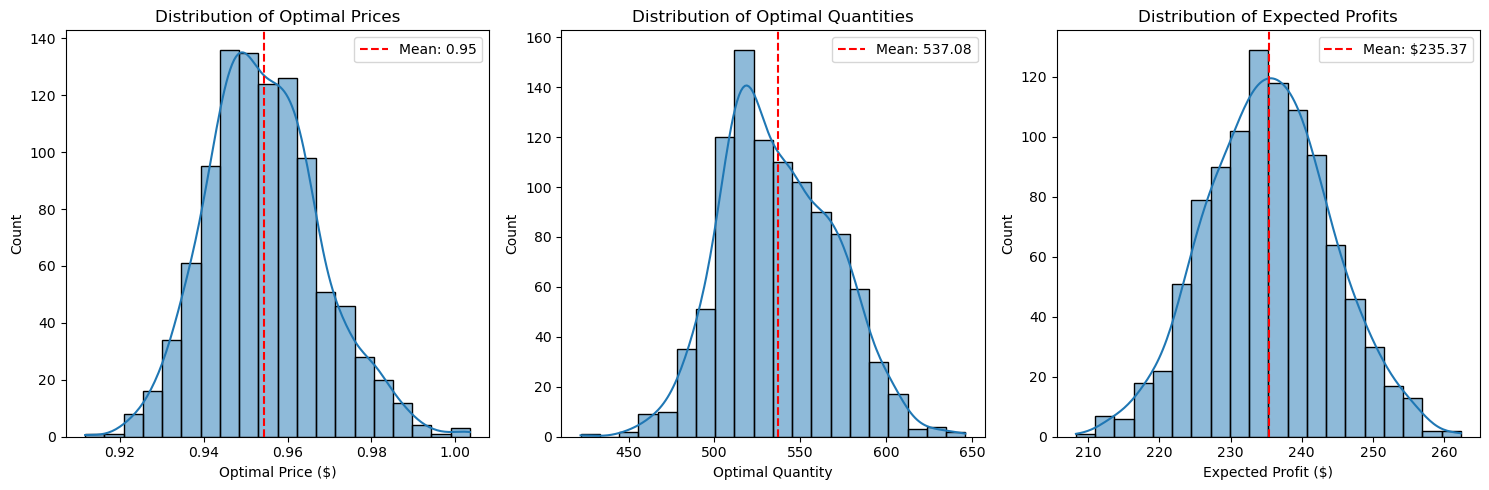

<Figure size 640x480 with 0 Axes>

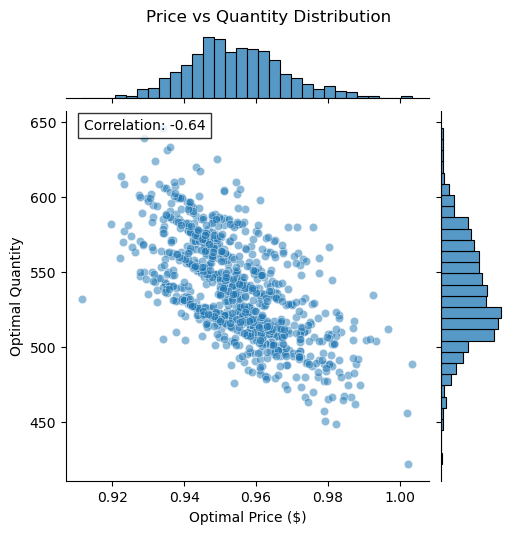


Summary Statistics:
Optimal Price:
  Mean: $0.95
  Std Dev: $0.01
  95% CI: [$0.93, $0.98]

Optimal Quantity:
  Mean: 537.08
  Std Dev: 32.53
  95% CI: [479.88, 601.46]

Expected Profit:
  Mean: $235.37
  Std Dev: $8.71
  95% CI: [$218.19, $252.85]


In [32]:
# First set of histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram of optimal prices
sns.histplot(optimal_prices, kde=True, bins=20, ax=axes[0])
axes[0].axvline(np.mean(optimal_prices), color='r', linestyle='--', 
                label=f'Mean: {np.mean(optimal_prices):.2f}')
axes[0].set_xlabel('Optimal Price ($)')
axes[0].set_title('Distribution of Optimal Prices')
axes[0].legend()
plt.tight_layout()
plt.savefig('optimal_prices_histogram.png', dpi=300)  

# Histogram of optimal quantities
sns.histplot(optimal_quantities, kde=True, bins=20, ax=axes[1])
axes[1].axvline(np.mean(optimal_quantities), color='r', linestyle='--',
                label=f'Mean: {np.mean(optimal_quantities):.2f}')
axes[1].set_xlabel('Optimal Quantity')
axes[1].set_title('Distribution of Optimal Quantities')
axes[1].legend()
plt.tight_layout()
plt.savefig('optimal_quantities_histogram.png', dpi=300)  

# Histogram of profits
sns.histplot(profits, kde=True, bins=20, ax=axes[2])
axes[2].axvline(np.mean(profits), color='r', linestyle='--',
                label=f'Mean: ${np.mean(profits):.2f}')
axes[2].set_xlabel('Expected Profit ($)')
axes[2].set_title('Distribution of Expected Profits')
axes[2].legend()
plt.tight_layout()
plt.savefig('expected_profits_histogram.png', dpi=300)  # Save as a separate image
plt.show()

plt.tight_layout()
plt.show()

# jointplot for price vs quantity
joint_plot = sns.jointplot(
    x=optimal_prices,
    y=optimal_quantities,
    kind='scatter',
    height=5,
    marginal_kws=dict(bins=30),
    joint_kws={'alpha': 0.5}
)

# Addition of correlation coefficient to the joint plot
corr = np.corrcoef(optimal_prices, optimal_quantities)[0,1]
joint_plot.ax_joint.text(0.05, 0.95, f'Correlation: {corr:.2f}',
                        transform=joint_plot.ax_joint.transAxes,
                        bbox=dict(facecolor='white', alpha=0.8))

# labels
joint_plot.ax_joint.set_xlabel('Optimal Price ($)')
joint_plot.ax_joint.set_ylabel('Optimal Quantity')
plt.suptitle('Price vs Quantity Distribution', y=1.02)

plt.savefig('price_vs_quantity_jointplot.png', dpi=300)  # Save the joint plot separately
plt.show()

plt.show()

# Printing of summary statistics
print("\nSummary Statistics:")
print(f"Optimal Price:")
print(f"  Mean: ${np.mean(optimal_prices):.2f}")
print(f"  Std Dev: ${np.std(optimal_prices):.2f}")
print(f"  95% CI: [${np.percentile(optimal_prices, 2.5):.2f}, ${np.percentile(optimal_prices, 97.5):.2f}]")

print(f"\nOptimal Quantity:")
print(f"  Mean: {np.mean(optimal_quantities):.2f}")
print(f"  Std Dev: {np.std(optimal_quantities):.2f}")
print(f"  95% CI: [{np.percentile(optimal_quantities, 2.5):.2f}, {np.percentile(optimal_quantities, 97.5):.2f}]")

print(f"\nExpected Profit:")
print(f"  Mean: ${np.mean(profits):.2f}")
print(f"  Std Dev: ${np.std(profits):.2f}")
print(f"  95% CI: [${np.percentile(profits, 2.5):.2f}, ${np.percentile(profits, 97.5):.2f}]")